In [78]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

Preprocessing

In [9]:
#load data
df = pd.read_excel("/content/SafeBite_dataset.xlsx")
print(df.head())

  Restaurnt name Restaurant Type Menu Selection             Food Name  \
0      Taco Bell       fast food          tacos      soft taco (beef)   
1      Taco Bell       fast food          tacos   crunchy taco (beef)   
2      Taco Bell       fast food          tacos   soft taco (chicken)   
3      Taco Bell       fast food          tacos  crunchy taco supreme   
4      Taco Bell       fast food       burritos          beef burrito   

                                Full Ingredient List  Milk  eggs  \
0  Flour tortilla, seasoned beef, lettuce, chedda...     1     0   
1                  Corn shell, beef, lettuce, cheese     1     0   
2   Flour tortilla, grilled chicken, lettuce, cheese     1     0   
3  Corn shell, beef, tomatoes, lettuce, cheese, s...     1     0   
4  Flour tortilla, beef, rice, nacho cheese, sour...     1     0   

   wheat/gluten  soy  peanuts  tree nuts  fish  shellfish  sesame  \
0             1    0        0          0     0          0       0   
1             

In [10]:
#standardize column names
df.columns = (
    df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
    .str.replace("(", "")
    .str.replace(")", "")
)


In [11]:
#clean text columns
text_cols = [
    "restaurnt_name",
    "restaurant_type",
    "menu_selection",
    "food_name",
    "full_ingredient_list"
]

for col in text_cols:
  df[col] = (
      df[col]
      .astype(str)
      .str.lower()
      .str.strip()
  )

In [12]:
#validate allergen columns

# Ensure column names are correct after previous steps
df.rename(columns={"wheat/gluten": "wheat_gluten"}, inplace=True)

# Corrected list of allergen columns
allergen_cols = [
    "milk",
    "eggs",
    "wheat_gluten",
    "soy",
    "peanuts",
    "tree_nuts",
    "fish",
    "shellfish",
    "sesame"
]

for col in allergen_cols:
  df[col] = df[col].fillna(0).astype(int)
  df[col] = df[col].apply(lambda x: 1 if x == 1 else 0)

In [13]:
#standardize allergy safety status
df["allergy_safety_status"] = (
    df["allergy_safety_status"]
    .str.lower()
    .str.strip()
)

valid_status = ["safe", "caution", "unsafe"]
df = df[df["allergy_safety_status"].isin(valid_status)]

In [14]:
#duplicate items
duplicate_rows = df[df.duplicated()]

if not duplicate_rows.empty:
    print("Duplicate rows found:")
    display(duplicate_rows)
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [15]:
#missing ingredient handling
#df["full_ingredient_list"] = df["full_ingredient_list"].fillna("unknown ingredients")

In [16]:
#final preprocessing check
print(df.isnull().sum())
print(df['allergy_safety_status'].value_counts)

restaurnt_name           0
restaurant_type          0
menu_selection           0
food_name                0
full_ingredient_list     0
milk                     0
eggs                     0
wheat_gluten             0
soy                      0
peanuts                  0
tree_nuts                0
fish                     0
shellfish                0
sesame                   0
allergy_safety_status    0
dtype: int64
<bound method IndexOpsMixin.value_counts of 0       unsafe
1       unsafe
2       unsafe
3       unsafe
4       unsafe
         ...  
1034    unsafe
1035    unsafe
1036    unsafe
1037    unsafe
1038    unsafe
Name: allergy_safety_status, Length: 956, dtype: object>


Personalized Allergy Profile

In [19]:
def get_user_allergy_profile():
  print("Please enter yes or no for the following allergies:\n")

  user_profile = {}
  for allergen in allergen_cols:
    response = input(f"Are you allergic to {allergen}? (yes/no): ").strip().lower()
    user_profile[allergen] = 1 if response == "yes" else 0

  return user_profile


In [20]:
def allergy_profile_to_vector(user_profile):
  return [user_profile[a] for a in allergen_cols]

In [22]:
#collect user entered allergy data
user_allergy_profile = get_user_allergy_profile()

#convert to vector format
user_allergy_vector = allergy_profile_to_vector(user_allergy_profile)

print("\nUser Allergy Profile Vector:")
print(user_allergy_vector)



Please enter yes or no for the following allergies:

Are you allergic to milk? (yes/no): no
Are you allergic to eggs? (yes/no): yes
Are you allergic to wheat_gluten? (yes/no): no
Are you allergic to soy? (yes/no): no
Are you allergic to peanuts? (yes/no): yes
Are you allergic to tree_nuts? (yes/no): no
Are you allergic to fish? (yes/no): no
Are you allergic to shellfish? (yes/no): yes
Are you allergic to sesame? (yes/no): no

User Allergy Profile Vector:
[0, 1, 0, 0, 1, 0, 0, 1, 0]


Dish Safety Scoring

In [24]:
#clean status columns
df["allergy_safety_status"] = (df["allergy_safety_status"].str.lower().str.strip())

In [29]:
#correct safety scoring function
def score_dish_safety(dish_row, user_profile):
  for allergen, allergic in user_profile.items():
    if allergic == 1 and dish_row[allergen] == 1:
      return "unsafe"

  if dish_row['allergy_safety_status'] == "caution":
    return "caution"

  return "safe"

In [30]:
df['personalized_safety_status'] = df.apply(lambda row: score_dish_safety(row, user_allergy_profile),axis=1)

working model

In [38]:
#text feature from ingredients
tfidf = TfidfVectorizer(
    max_features = 3000,
    stop_words = "english"
)

X_test = tfidf.fit_transform(df["full_ingredient_list"])

In [39]:
#including allergy flags as feature
X_allergens = df[allergen_cols].values

In [40]:
#combine text and allergy features
X = hstack( [X_test, X_allergens])

In [44]:
#encode target variables
le = LabelEncoder()
y = le.fit_transform(df["allergy_safety_status"])

print(le.classes_)

['caution' 'safe' 'unsafe']


In [47]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42,
    stratify = y
)

In [49]:
#useing logistic regression to train baseline model
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [51]:
#generate model prediction
y_pred = model.predict(X_test)

Evaluation

In [59]:
classification = classification_report(y_test, y_pred, target_names = le.classes_)
print("Classification Report: \n",classification)

Classification Report: 
               precision    recall  f1-score   support

     caution       0.82      0.64      0.72        36
        safe       0.89      1.00      0.94        32
      unsafe       0.91      0.94      0.92       124

    accuracy                           0.89       192
   macro avg       0.87      0.86      0.86       192
weighted avg       0.89      0.89      0.89       192



In [62]:
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n ", confusion)

Confusion Matrix: 
  [[ 23   1  12]
 [  0  32   0]
 [  5   3 116]]


Checking false negative

In [70]:
df["ml_status"] = le.inverse_transform(model.predict(X))

false_negative = df[
    (df["allergy_safety_status"] == "unsafe") &
    (df["ml_status"] == "safe")
][["food_name", "full_ingredient_list"]]

print("False negative count:", len(false_negative))
print(false_negative.head())

False negative count: 4
            food_name                     full_ingredient_list
330  mussels marinara           mussels, tomato, garlic, herbs
728       lamb tagine            lamb, prunes, almonds, spices
741           ceviche  shrimp, lime, cilantro, onions, peppers
813       shrimp bowl         shrimp, rice, beans, salsa, lime


In [71]:
#rule based overrides (ml never overrides known allergy risks)
df["final_status"] = df.apply(
    lambda row: "unsafe"
    if row["allergy_safety_status"] == "unsafe"
    else row["ml_status"],
    axis = 1
)

Updated evaluation

In [73]:
#encode final labels
le_final = LabelEncoder()

y_true = le_final.fit_transform(df["allergy_safety_status"])
y_final_pred = le_final.transform(df["final_status"])

In [75]:
#accuracy
accuracy = accuracy_score(y_true, y_final_pred)
print("Final accuracy:\n", accuracy)

Final accuracy:
 0.9372384937238494


In [77]:
#confirm false negative is eliminated
false_negatives_after = df[
    (df["allergy_safety_status"] == "unsafe") &
    (df["final_status"] == "safe")
]

print("False Negatives After Override:", len(false_negatives_after))


False Negatives After Override: 0


Error analysisvisualization

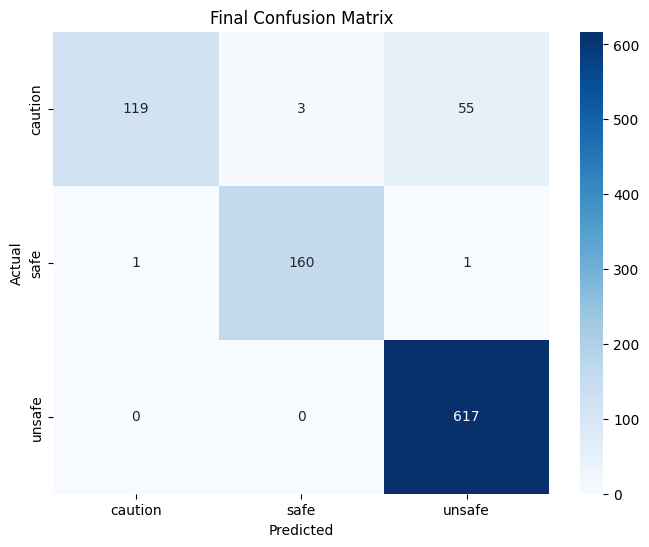

In [82]:
#confusion matrix final system
cm = confusion_matrix(y_true, y_final_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap='Blues',
            xticklabels=le_final.classes_,
            yticklabels=le_final.classes_
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Confusion Matrix")
plt.show()

Streamlit app